In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path

a) Creates 100 random predictor variables, X, and 100 noise values.

In [2]:
np.random.seed(1)
X = np.random.normal(0,1,100)
noise = np.random.normal(0,1,100)
X

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
       -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
       -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
       -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
       -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
       -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
       -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
        0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
        0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
       -0.75439794,  1.25286816,  0.51292982, -0.29809284,  0.48851815,
       -0.07557171,  1.13162939,  1.51981682,  2.18557541, -1.39

In [3]:
Y = 6 + 5*X + 4*(X**2) + 3*(X**3) + noise
Y

array([ 3.70860850e+01,  4.97586727e+00,  4.43646955e+00,  2.12797914e+00,
        1.41722379e+01, -2.07242959e+01,  4.35776354e+01,  2.23479676e+00,
        7.83354184e+00,  4.98798328e+00,  2.98653668e+01, -1.32396476e+01,
        5.54933748e+00,  3.64026182e+00,  2.15332803e+01,  3.54874338e-02,
        5.20270976e+00,  1.04795084e+00,  7.33984012e+00,  1.12755717e+01,
        1.31799082e+00,  2.06901381e+01,  1.72317897e+01,  1.18702160e+01,
        1.40857095e+01,  4.72856481e+00,  7.06803999e+00,  2.70356223e+00,
        3.69067348e+00,  1.10877606e+01,  3.28169402e+00,  3.85460226e+00,
        2.24944177e+00,  3.37062440e+00,  4.33152882e+00,  5.31378175e+00,
        1.74306248e+00,  6.28618391e+00,  3.98386275e+01,  1.31850805e+01,
        4.98027683e+00,  2.51360091e+00,  4.11478345e+00,  4.12139089e+01,
        6.79422328e+00,  3.80036813e+00,  7.19906932e+00,  6.25570701e+01,
        6.89624664e+00,  1.19976771e+01,  7.63228175e+00,  2.16911139e+00,
        2.07347398e+00,  

In [6]:
data = pd.DataFrame({'X': X, 'Y': Y})
data.shape

(100, 2)

In [7]:
def nCp (sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n,p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS+2*p*sigma2)/n

In [8]:
for i in range(2, 11):
    data[f'X{i}'] = data['X'] ** i

In [21]:
data[:1]

,X,Y,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.624345,37.086085,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436


In [22]:

design = MS(data.columns.drop('Y')).fit(data)
Y = np.array(data['Y'])
X = design.transform(data)
sigma2 = OLS(Y,X).fit().scale

In [23]:
neg_Cp = partial(nCp, sigma2)

In [24]:
strategy = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))

In [26]:
data_MSE = sklearn_selected(OLS, strategy)
data_MSE.fit(data, Y)
data_MSE.selected_state_

('X', 'X10', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9')

In [27]:
data_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
data_Cp.fit(data, Y)
data_Cp.selected_state_  

('X', 'X2', 'X3', 'X6')

In [44]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path=sklearn_selection_path(OLS,strategy)


In [50]:
full_path.fit(data, Y)
Yhat_in = full_path.predict(data)
Yhat_in.shape


sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x000001CC513A7AD0>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'], dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x000001CC4A93AFC0>, 10), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x000001CC4A93B100>, 10)))

(0.0, 300.0)

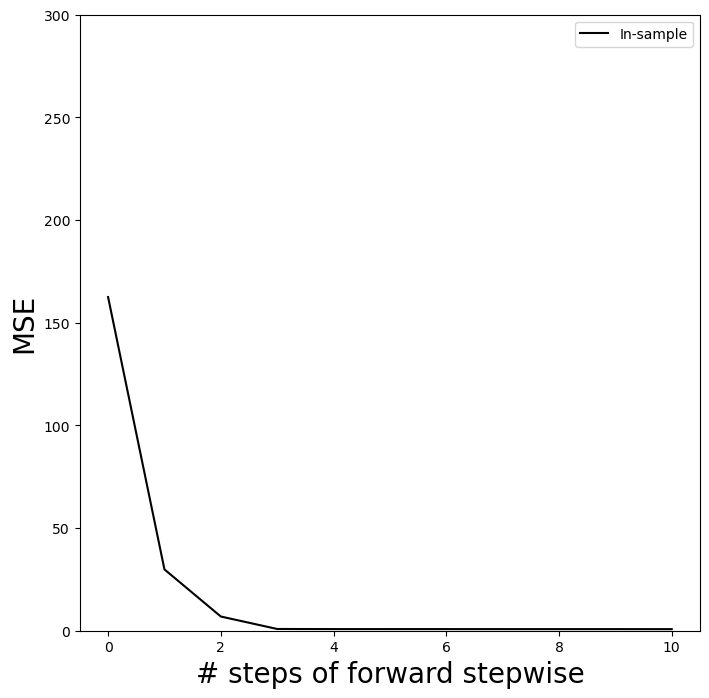

In [35]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),insample_mse, 'k', label ="In-sample")
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0,300])

In [36]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, data, Y, cv=kfold)
Yhat_cv.shape

(100, 11)

In [37]:
cv_mse=[]
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx]-Y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(11, 5)

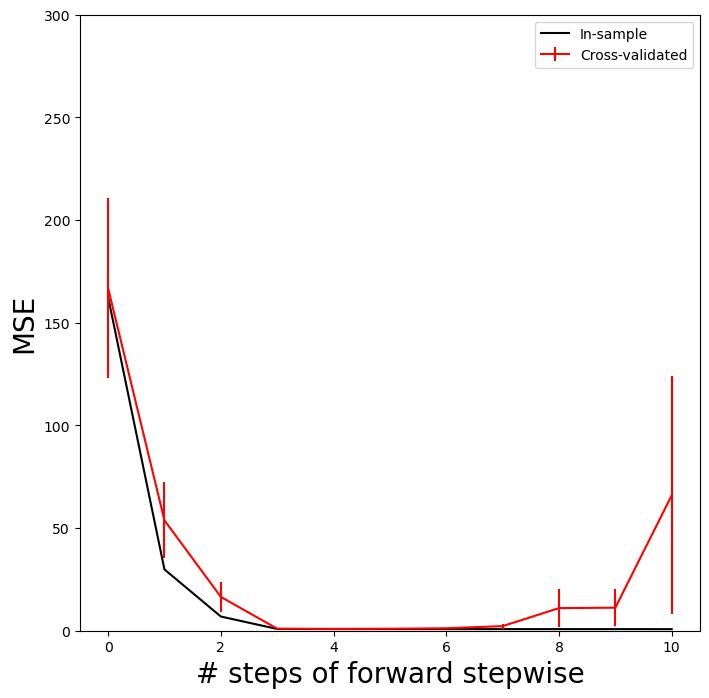

In [38]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1)/np.sqrt(K), label="Cross-validated", c="r")
ax.set_ylim([0,300])
ax.legend()
mse_fig

In [39]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(data.iloc[train_idx],Y[train_idx])
    Yhat_val = full_path.predict(data.iloc[test_idx])
    errors =(Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

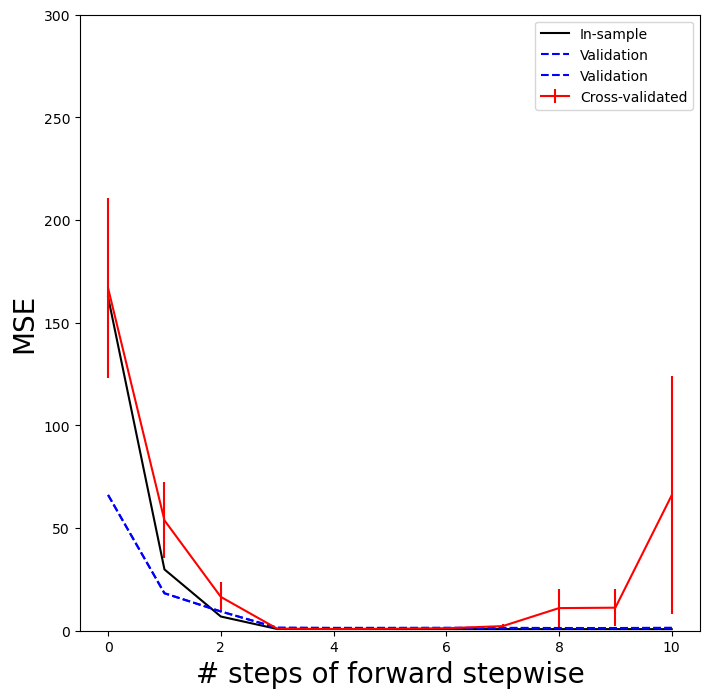

In [41]:
ax.plot(np.arange(n_steps), validation_mse, 'b--', label="Validation")
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([0,300])
ax.legend()
mse_fig

In [45]:
D = design.fit_transform(data)
D = D.drop('intercept',axis=1)
X = np.asarray(D)

In [46]:
path = fit_path(X,Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  3
Iteration: 4. Number of non-zeros:  6
Iteration: 5. Number of non-zeros:  10


In [49]:
path[2]

{'B': array([5.05078476, 3.94101009, 2.97904199, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'B0': 6.199077236259486,
 'lambda_0': 0.007597078677585356,
 'M': 1.051770741314612,
 'Time_exceeded': False}

In [59]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path=sklearn_selection_path(OLS,strategy)
full_path.fit(data, Y)
Yhat_in = full_path.predict(data)





In [60]:
scaler = StandardScaler(with_mean=True, with_std=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler',scaler),('lasso',lassoCV)])
pipeCV.fit(X,Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.011517267917597392

In [61]:
# Xs = X - X.mean(0)[None,:]
lambdas, soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1,n_alphas=100)[:2]

c:\Users\ajpra\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.181514529092965, tolerance: 2.629671882710574
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ajpra\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.284508857757828, tolerance: 2.629671882710574
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ajpra\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.053507020647885, tolerance: 2.629671882710574
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ajpra\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: 